In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import re

In [42]:
df = pd.read_csv('/content/drive/MyDrive/train (1).csv')

In [43]:
df = df.dropna(subset=['actual_price'])

In [4]:
df.shape

(15367, 22)

In [5]:
df.columns

Index(['id', 'actual_price', 'price', 'start_date', 'close_date',
       'sale_end_date', 'brand', 'model', 'generation', 'modification',
       'equipment', 'body_type', 'color', 'year', 'mileage', 'owners_count',
       'latitude', 'longitude', 'crashes', 'is_taxi', 'is_carsharing',
       'description'],
      dtype='object')

In [50]:
test.columns

Index(['id', 'sale_end_date', 'brand', 'model', 'generation', 'modification',
       'equipment', 'body_type', 'color', 'year', 'mileage', 'owners_count',
       'latitude', 'longitude', 'crashes', 'is_taxi', 'is_carsharing',
       'description'],
      dtype='object')

In [6]:
df.dtypes

id                 int64
actual_price     float64
price            float64
start_date        object
close_date        object
sale_end_date     object
brand             object
model             object
generation        object
modification      object
equipment         object
body_type         object
color             object
year             float64
mileage            int64
owners_count      object
latitude         float64
longitude        float64
crashes          float64
is_taxi          float64
is_carsharing    float64
description       object
dtype: object

In [13]:
df.brand.value_counts()

Toyota        41113
Kia           34369
ВАЗ (LADA)    32794
Volkswagen    30597
Nissan        30311
              ...  
Alfa Romeo       26
Pontiac          25
Богдан           15
GMC              10
SEAT              7
Name: brand, Length: 65, dtype: int64

In [41]:
import pandas as pd
from datetime import datetime

# Загрузим ваш датасет
# Предположим, что df - это ваш DataFrame
# df = pd.read_csv("ваш_файл.csv")

# 1. Длительность эксплуатации

def process(df):
    df.is_taxi = df.is_taxi.fillna(0)
    df['is_carsharing'] = df['is_carsharing'].fillna(2)

    current_year = datetime.now().year
    df['years_in_use'] = current_year - df['year']

    # 2. Пробег в год
    df['mileage_per_year'] = df['mileage'] / df['years_in_use']

    # 4. Средняя цена автомобиля по бренду и модели
    try:
      df['avg_price_by_brand_model'] = df.groupby(['brand', 'model'])['actual_price'].transform('mean')
    except:
      pass

    # 5. Категоризация года выпуска
    bins = [0, 3, 7, float('inf')]
    labels = ['новые', 'средние', 'старые']
    df['year_category'] = pd.cut(df['years_in_use'], bins=bins, labels=labels, right=False)
    df['year_category'] = df['year_category'].astype('object')

    # 6. Признаки наличия аварий и статуса такси/каршеринга
    df['has_crashes'] = df['crashes'].apply(lambda x: 1 if x > 0 else 0)
    df['is_taxi'] = df['is_taxi'].astype(int)
    df['is_carsharing'] = df['is_carsharing'].astype(int)

    # 7. Длина описания
    df['description_length'] = df['description'].apply(lambda x: len(str(x).split()))


    df['sale_end_date'] = pd.to_datetime(df['sale_end_date'], errors='coerce')

    df['sale_end_year'] = df['sale_end_date'].dt.year.fillna(0).astype(int)
    df['sale_end_month'] = df['sale_end_date'].dt.month.fillna(0).astype(int)
    df['sale_end_day'] = df['sale_end_date'].dt.day.fillna(0).astype(int)

    # Удаление временных столбцов
    df = df.drop(['sale_end_date'], axis=1)
    try:
      df = df.drop(['start_date', 'close_date'], axis=1)
    except:
      pass

    df['Engine'] = df['modification'].apply(lambda x: float(x.split('(')[1].split()[0]))
    df['generation'] = df['generation']

    df['num_gen'] = df['generation'].apply(lambda x: x.split()[0])


    df.owners_count = df.owners_count.apply(lambda x : int(x) if x != '> 3' else 5)
    df = df.fillna(-1)
    df[['brand','model','generation','modification','equipment','body_type','color','description','year_category', 'num_gen']] = df[['brand','model','generation','modification','equipment','body_type','color','description','year_category', 'num_gen']].replace(-1, 'empty')

    return df



In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import pickle
from sklearn.metrics import roc_auc_score
# import optuna
import catboost as cb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

In [6]:
!pip install catboost

In [8]:
import catboost as cb
from sklearn.metrics import r2_score

class Boosting:

    def __init__(self, X_train, X_val, y_train, y_val, cat_features, params = None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(data = X_train, label = y_train, cat_features = cat_features)
        self.val_pool = cb.Pool(data = X_val, label = y_val, cat_features = cat_features)
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostRegressor(
                learning_rate = 0.303,
                depth = 3,
                l2_leaf_reg = 2.437,
                random_seed = 42,
                min_data_in_leaf = 30,
                one_hot_max_size = 40,
                colsample_bylevel = 0.079,
                loss_function = 'RMSE',
                task_type = 'CPU',
                iterations = 1000,
                use_best_model = True,
                verbose = 100,
                thread_count = -1,
                early_stopping_rounds = 100,
                eval_metric = 'R2',
                boosting_type = 'Plain',
                bootstrap_type = 'MVS'
            )
        else:
            self.params["verbose"] = 100
            self.params["iterations"] = 1000
            model = cb.CatBoostRegressor(**self.params)

        model.fit(
            self.train_pool,
            eval_set=self.val_pool
        )

        y_train_pred = model.predict(self.X_train)
        y_val_pred = model.predict(self.X_val)

        r2_tr_score= r2_score(self.y_train, y_train_pred)
        r2_val_score= r2_score(self.y_val, y_val_pred)

        print("R^2 на обучающей выборке:", r2_tr_score)
        print("R^2 на валидационной выборке:", r2_val_score)

        self.model=model

    def optimize_hyperparams(self):

        def objective(trial):
            params={
                "learning_rate": trial.suggest_loguniform("learning_rate",1e-5,1e0),
                "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg",1e-2,3e0),
                "colsample_bylevel": trial.suggest_float("colsample_bylevel",0.01,0.1,log=True),
                "depth": trial.suggest_int("depth",2,5),
                "boosting_type": trial.suggest_categorical("boosting_type",["Ordered","Plain"]),
                "bootstrap_type": trial.suggest_categorical("bootstrap_type",["Bayesian","Bernoulli","MVS"]),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",2,50),
                "one_hot_max_size": trial.suggest_int("one_hot_max_size",2,50),
                "iterations": trial.suggest_int("iterations",500,3500),
                "eval_metric":"R2"
            }

            if params["bootstrap_type"]=="Bayesian":
                params["bagging_temperature"]=trial.suggest_float("bagging_temperature",0,10)
            elif params["bootstrap_type"]=="Bernoulli":
                params["subsample"]=trial.suggest_float("subsample",0.1,1,log=True)

            model=cb.CatBoostRegressor(
            loss_function='RMSE',
            random_seed=42,
            task_type='CPU',
            use_best_model=True,
            verbose=False,
            **params
            )

            model.fit(
            self.train_pool,
            eval_set=self.val_pool
            )

            y_pred=model.predict(self.X_val)

            r2=r2_score(self.y_val,y_pred)

            return r2

        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
        study.optimize(objective, n_trials = 100, timeout = 600)

        self.best_params = study.best_params

        print("Best params:", self.best_params)


    def save_model(self, file_path):
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx])
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)


    def top_feats_selection(self):

        top = []
        r2_tr = []
        r2_val = []

        for col in tqdm(self.top_features):

            top.append(col)
            top_cat = list(set(self.cat_features) & set(top))

            train_pool = cb.Pool(data = self.X_train[top], label = self.y_train, cat_features = top_cat)
            val_pool = cb.Pool(data = self.X_val[top], label = self.y_val, cat_features = top_cat)

            if self.params is None:
                model = cb.CatBoostRegressor(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'RMSE',
                    task_type = 'CPU',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'R2',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
                path = "no_optuna_top_features.xlsx"
            else:
                self.params["verbose"] = 0
                self.params["iterations"] = 500
                path = "optuna_top_features.xlsx"
                model = cb.CatBoostRegressor(**self.params)

            model.fit(
                train_pool,
                eval_set=val_pool
            )

            y_train_pred=model.predict(self.X_train[top])
            y_val_pred=model.predict(self.X_val[top])

            r2_tr_score=r2_score(self.y_train,y_train_pred)
            r2_val_score=r2_score(self.y_val,y_val_pred)

            r2_tr.append(r2_tr_score)
            r2_val.append(r2_val_score)

        plt.figure(figsize=(15,10))
        plt.plot(range(len(self.top_features)),r2_tr,marker='o',label='Train')
        plt.plot(range(len(self.top_features)),r2_val,marker='o',label='Valid')
        plt.xlabel("Number of Top Features")
        plt.ylabel("R^2")
        plt.title("R^2 on Top-K Features")
        plt.legend()
        plt.show()

        stats=pd.DataFrame({
        "TRAIN":r2_tr,
        "VALID":r2_val
        })

        stats.to_excel(path,index=False)


    def one_factor_r2(self):
        story = pd.DataFrame()

        for feature in tqdm(self.X_train.columns):
            if self.params is None:
                model = cb.CatBoostRegressor(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'RMSE',
                    task_type = 'CPU',
                    iterations = 2000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'R2',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
                path = "no_optuna_one_factor_r2.xlsx"
            else:
                self.params["verbose"] = False
                self.params["iterations"] = 500
                path = "optuna_one_factor_r2.xlsx"
                model = cb.CatBoostRegressor(**self.params)

            if len(self.X_train[feature].unique()) > 1:
                if feature in self.cat_features:
                    train_pool = cb.Pool(data=self.X_train[[feature]], label=self.y_train, cat_features=[feature])
                    val_pool = cb.Pool(data=self.X_val[[feature]], label=self.y_val, cat_features=[feature])
                else:
                    train_pool=cb.Pool(data=self.X_train[[feature]],label=self.y_train)
                    val_pool=cb.Pool(data=self.X_val[[feature]],label=self.y_val)

                model.fit(
                    train_pool,
                    eval_set=val_pool
                )

                y_train_pred=model.predict(self.X_train[[feature]])
                y_val_pred=model.predict(self.X_val[[feature]])

                r2_tr_score=r2_score(self.y_train,y_train_pred)
                r2_val_score=r2_score(self.y_val,y_val_pred)

                story=story.append(pd.DataFrame({
                'features':[feature],
                'train':[r2_tr_score],
                'valid':[r2_val_score]
                }),ignore_index=True)

            else:
                print(f"Feature {feature} has only one unique value. Ignoring.")

        plt.figure(figsize=(10,7))
        plt.bar(range(len(story['features'])),story['train'],align='center',label='Train')
        plt.bar(range(len(story['features'])),story['valid'],align='edge',label='Valid')
        plt.xlabel("Features")
        plt.ylabel("R^2")
        plt.title("One-Factor R^2")
        plt.xticks(range(len(story['features'])),story['features'],rotation=45)
        plt.legend()
        plt.tight_layout()
        story.to_excel(path,index=False)

In [45]:
df = process(df)

In [46]:
df.columns

Index(['id', 'actual_price', 'price', 'brand', 'model', 'generation',
       'modification', 'equipment', 'body_type', 'color', 'year', 'mileage',
       'owners_count', 'latitude', 'longitude', 'crashes', 'is_taxi',
       'is_carsharing', 'description', 'years_in_use', 'mileage_per_year',
       'avg_price_by_brand_model', 'year_category', 'has_crashes',
       'description_length', 'sale_end_year', 'sale_end_month', 'sale_end_day',
       'Engine', 'num_gen'],
      dtype='object')

In [47]:
test = process(test)

In [65]:
df_aggregated = df.groupby(['brand', 'model'], as_index=False).agg({'avg_price_by_brand_model': 'mean'})
df_test = pd.merge(test, df_aggregated[['brand', 'model', 'avg_price_by_brand_model']], on=['brand', 'model'], how='left')


In [66]:
df_test.shape

(1611, 28)

In [48]:
df_test = pd.merge(test, df[['brand', 'model', 'avg_price_by_brand_model']], on=['brand', 'model'], how='left')

In [15]:
df_test.columns

Index(['id', 'brand', 'model', 'generation', 'modification', 'equipment',
       'body_type', 'color', 'year', 'mileage', 'owners_count', 'latitude',
       'longitude', 'crashes', 'is_taxi', 'is_carsharing', 'description',
       'years_in_use', 'mileage_per_year', 'year_category', 'has_crashes',
       'description_length', 'sale_end_year', 'sale_end_month', 'sale_end_day',
       'Engine', 'num_gen', 'avg_price_by_brand_model'],
      dtype='object')

In [26]:
test.columns

Index(['id', 'sale_end_date', 'brand', 'model', 'generation', 'modification',
       'equipment', 'body_type', 'color', 'year', 'mileage', 'owners_count',
       'latitude', 'longitude', 'crashes', 'is_taxi', 'is_carsharing',
       'description'],
      dtype='object')

In [49]:
df_x = df.drop(['actual_price', 'price', 'id'], axis=1)
df_y = df['actual_price']

In [50]:
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.1, random_state=42)

In [51]:
boosting = Boosting(X_train, X_val, y_train, y_val, cat_features = ['num_gen', 'brand','model','generation','modification','equipment','body_type','color', 'description','year_category'])

Init...
Init Finished!


  0%|          | 0/28 [00:00<?, ?it/s]

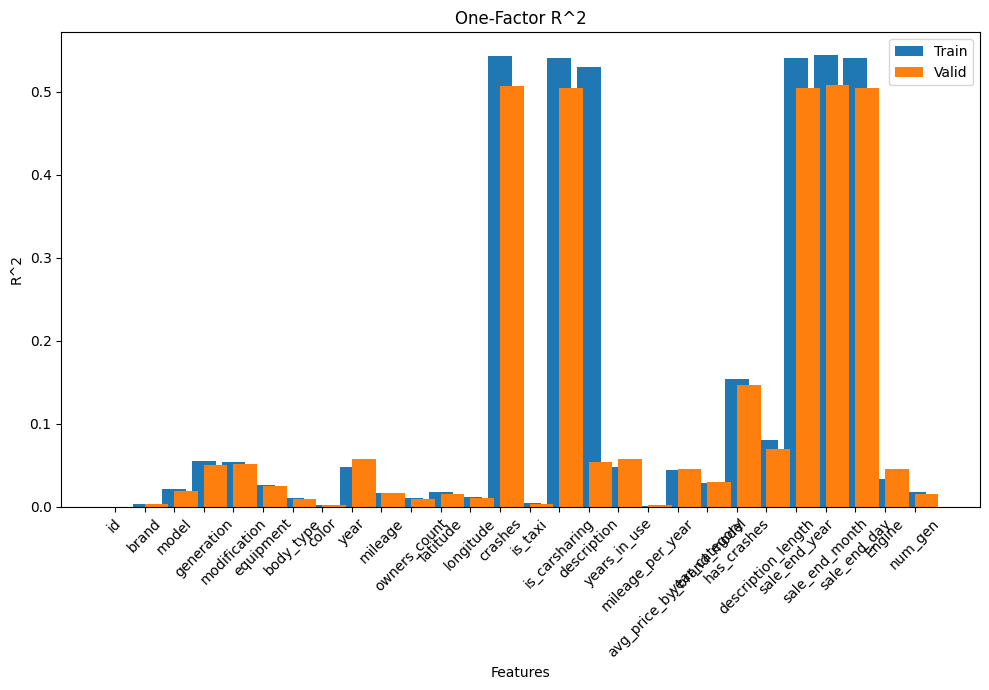

In [74]:
boosting.one_factor_r2()

In [52]:
boosting.train()

0:	learn: 0.2166246	test: 0.2491791	best: 0.2491791 (0)	total: 4.25ms	remaining: 4.24s
100:	learn: 0.9352313	test: 0.9296120	best: 0.9296120 (100)	total: 230ms	remaining: 2.05s
200:	learn: 0.9565405	test: 0.9505039	best: 0.9505039 (200)	total: 426ms	remaining: 1.69s
300:	learn: 0.9663223	test: 0.9594656	best: 0.9594656 (300)	total: 621ms	remaining: 1.44s
400:	learn: 0.9715019	test: 0.9640493	best: 0.9641104 (393)	total: 827ms	remaining: 1.24s
500:	learn: 0.9747102	test: 0.9672690	best: 0.9672894 (499)	total: 1.02s	remaining: 1.01s
600:	learn: 0.9765202	test: 0.9684858	best: 0.9687041 (586)	total: 1.24s	remaining: 824ms
700:	learn: 0.9781466	test: 0.9697876	best: 0.9698464 (697)	total: 1.43s	remaining: 608ms
800:	learn: 0.9793586	test: 0.9706220	best: 0.9706220 (800)	total: 1.63s	remaining: 406ms
900:	learn: 0.9804976	test: 0.9715813	best: 0.9715954 (898)	total: 1.82s	remaining: 200ms
999:	learn: 0.9814745	test: 0.9717898	best: 0.9718349 (995)	total: 2.02s	remaining: 0us

bestTest = 0.9

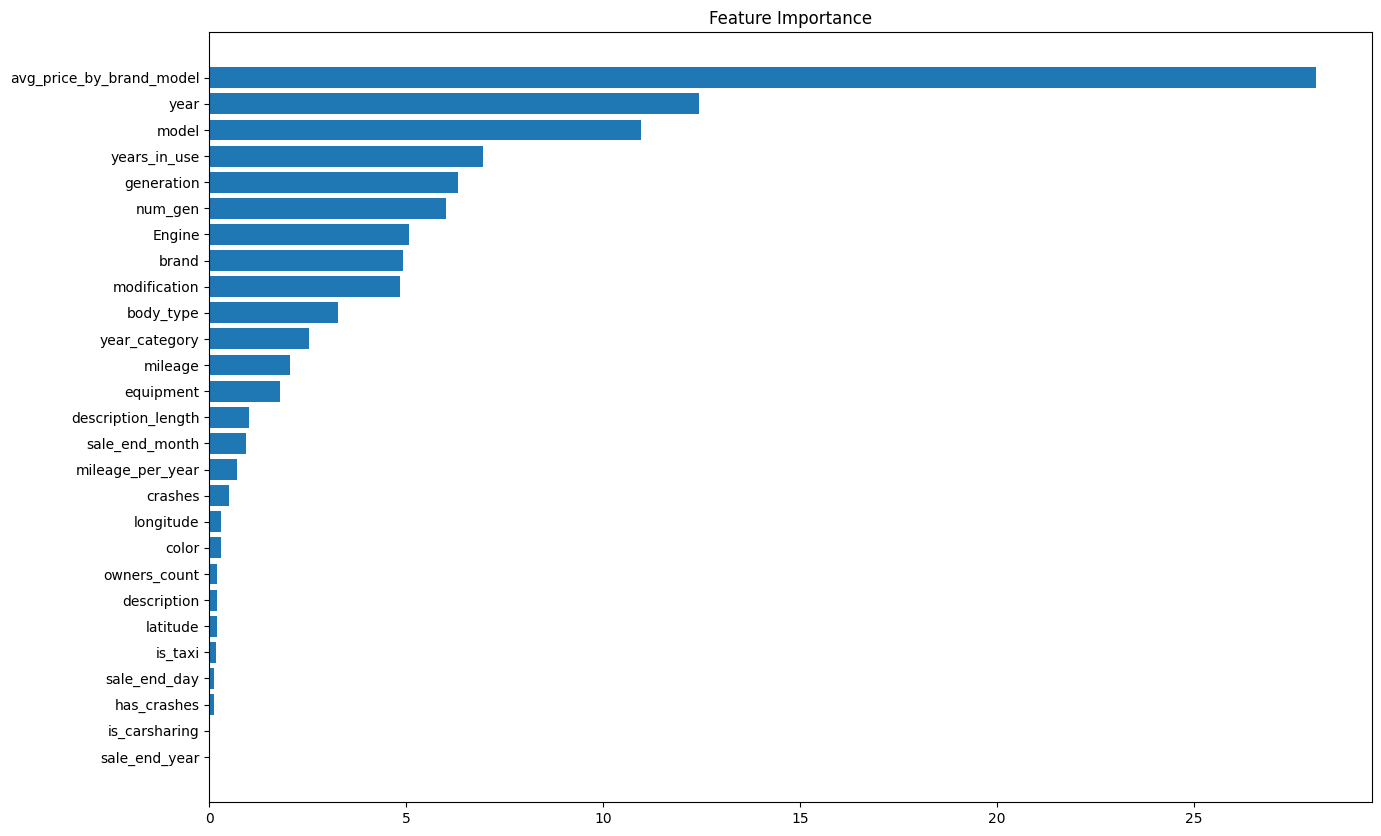

['avg_price_by_brand_model' 'year' 'model' 'years_in_use' 'generation'
 'num_gen' 'Engine' 'brand' 'modification' 'body_type' 'year_category'
 'mileage' 'equipment' 'description_length' 'sale_end_month'
 'mileage_per_year' 'crashes' 'longitude' 'color' 'owners_count'
 'description' 'latitude' 'is_taxi' 'sale_end_day' 'has_crashes'
 'is_carsharing' 'sale_end_year']


In [20]:
boosting.show_feats_imp()

  0%|          | 0/28 [00:00<?, ?it/s]

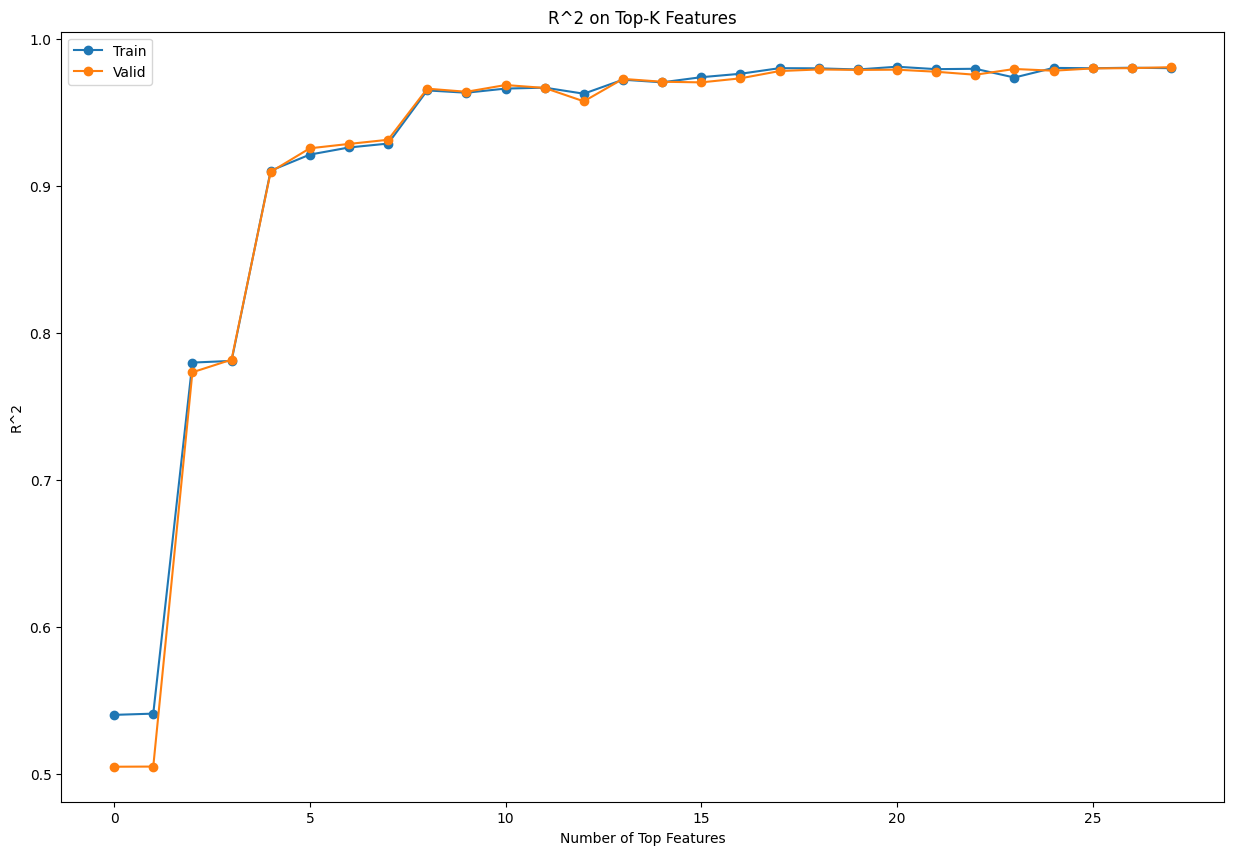

In [77]:
boosting.top_feats_selection()

In [44]:
test = pd.read_csv('/content/drive/MyDrive/val_public.csv')

In [23]:
df_test.

Index(['brand', 'model', 'generation', 'modification', 'equipment',
       'body_type', 'color', 'year', 'mileage', 'owners_count', 'latitude',
       'longitude', 'crashes', 'is_taxi', 'is_carsharing', 'description',
       'years_in_use', 'mileage_per_year', 'year_category', 'has_crashes',
       'description_length', 'sale_end_year', 'sale_end_month', 'sale_end_day',
       'Engine', 'num_gen', 'avg_price_by_brand_model'],
      dtype='object')

In [67]:
df_test = df_test.drop(['id'], axis=1)

In [68]:
df_test = df_test[df_x.columns]

In [69]:
df_test.shape

(1611, 27)

In [64]:
test.shape

(1611, 27)

In [73]:
preds = boosting.model.predict(df_test)

In [74]:
preds.shape

(1611,)

In [80]:
ans = pd.Series(preds)

In [81]:
ans.to_csv('/content/solution_final.csv', header=False, index=False)

In [78]:
pd.Series(preds).to_csv('/content/solution1.csv', header=False, index=False)

# Новый раздел

In [55]:
df_x.dtypes

brand                        object
model                        object
generation                   object
modification                 object
equipment                    object
body_type                    object
color                        object
year                        float64
mileage                       int64
owners_count                  int64
latitude                    float64
longitude                   float64
crashes                     float64
is_taxi                       int64
is_carsharing                 int64
description                  object
years_in_use                float64
mileage_per_year            float64
avg_price_by_brand_model    float64
year_category                object
has_crashes                   int64
description_length            int64
sale_end_year                 int64
sale_end_month                int64
sale_end_day                  int64
Engine                      float64
num_gen                      object
dtype: object

In [56]:
df_test.dtypes

brand                        object
model                        object
generation                   object
modification                 object
equipment                    object
body_type                    object
color                        object
year                        float64
mileage                       int64
owners_count                  int64
latitude                    float64
longitude                   float64
crashes                     float64
is_taxi                       int64
is_carsharing                 int64
description                  object
years_in_use                float64
mileage_per_year            float64
year_category                object
has_crashes                   int64
description_length            int64
sale_end_year                 int64
sale_end_month                int64
sale_end_day                  int64
Engine                      float64
num_gen                      object
avg_price_by_brand_model    float64
dtype: object

In [57]:
df_test.year_category

0          старые
1          старые
2          старые
3          старые
4          старые
           ...   
311195    средние
311196    средние
311197    средние
311198    средние
311199    средние
Name: year_category, Length: 311200, dtype: object

In [94]:
for j in ['brand','model','generation','modification','equipment','body_type','color','year_category', 'num_gen']:
  for i in test[j].unique():
    if i not in df_x[j].unique():
      print(j, i)

In [128]:
test.columns

Index(['id', 'brand', 'model', 'generation', 'modification', 'equipment',
       'body_type', 'color', 'year', 'mileage', 'owners_count', 'latitude',
       'longitude', 'crashes', 'is_taxi', 'is_carsharing', 'description',
       'years_in_use', 'mileage_per_year', 'year_category', 'has_crashes',
       'description_length', 'sale_end_year', 'sale_end_month', 'sale_end_day',
       'Engine', 'num_gen'],
      dtype='object')

In [129]:
df_x.columns

Index(['brand', 'model', 'generation', 'modification', 'equipment',
       'body_type', 'color', 'year', 'mileage', 'owners_count', 'latitude',
       'longitude', 'crashes', 'is_taxi', 'is_carsharing', 'description',
       'years_in_use', 'mileage_per_year', 'avg_price_by_brand_model',
       'year_category', 'has_crashes', 'description_length', 'sale_end_year',
       'sale_end_month', 'sale_end_day', 'Engine', 'num_gen'],
      dtype='object')